<a href="https://www.kaggle.com/code/safwanshamsir99/detect-dust-solar-pv?scriptVersionId=152525094" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [2]:
!pip install tensorflow

In [3]:
!pip install visualkeras

  Obtaining dependency information for aggdraw>=1.3.11 from https://files.pythonhosted.org/packages/da/05/8912c901a3965ec7117d6cc33eaec3888c717611f72ce69d8be62a01d149/aggdraw-1.3.18-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 13.8 MB/s eta 0:00:0000:010:01


In [4]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image
# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
import warnings
warnings.filterwarnings("ignore")
import visualkeras

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Functions

In [5]:
# View random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1) # randomly sample one file in that directory

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

In [6]:
# Function to plot the loss and accuracy
def plot_model_evaluation(hist):
    hist_keys = [i for i in hist.history.keys()]
    plt.figure()
    plt.plot(hist.history[hist_keys[0]])
    plt.plot(hist.history[hist_keys[2]])
    plt.legend(['train_loss','val_loss'])
    plt.title('Loss')
    plt.show()

    plt.figure()
    plt.plot(hist.history[hist_keys[1]])
    plt.plot(hist.history[hist_keys[3]])
    plt.legend(['train_acc','val_acc'])
    plt.title('Accuracy')
    plt.show()

In [7]:
def get_prediction(model, data):
    label = list(data.class_indices.keys())
    y_true = data.classes
    y_preds = model.predict(data)
    y_pred = np.argmax(y_preds, axis=1)

    return label, y_true, y_pred

In [8]:
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [9]:
def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a classification model.

  Args:
  -----
  y_true = true labels 
  y_pred = predicted labels 

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [10]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

# Exploratory Data Analysis (EDA)

Image shape: (3227, 4404, 3)


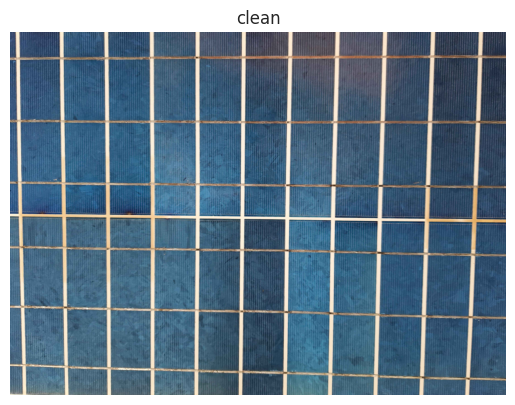

In [11]:
# View a random image from the clean solar panel dataset
clean_img = view_random_image(target_dir="/kaggle/input/solar-photovoltaics-panell-for-dust-dectection/dataset/",
                        target_class="clean")

Image shape: (3468, 4624, 3)


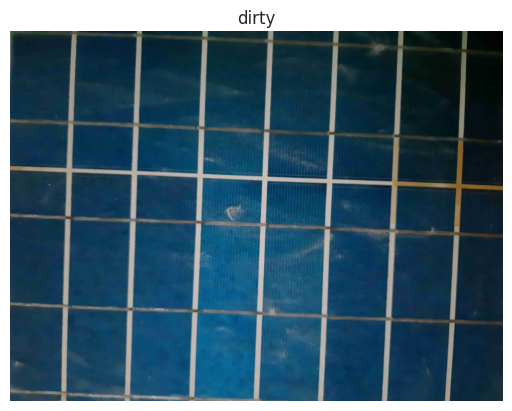

In [12]:
# View a random image from the dirty solar panel dataset
dirty_img = view_random_image(target_dir="/kaggle/input/solar-photovoltaics-panell-for-dust-dectection/dataset/",
                            target_class="dirty")

# Data Preprocessing

In [13]:
data = '/kaggle/input/solar-photovoltaics-panell-for-dust-dectection/dataset'
filepaths = []
labels = []

folds = os.listdir(data)
for fold in folds:
    foldpath = os.path.join(data, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
data = pd.concat([Fseries, Lseries], axis= 1)
data

filepaths labels
0    /kaggle/input/solar-photovoltaics-panell-for-d...  clean
1    /kaggle/input/solar-photovoltaics-panell-for-d...  clean
2    /kaggle/input/solar-photovoltaics-panell-for-d...  clean
3    /kaggle/input/solar-photovoltaics-panell-for-d...  clean
4    /kaggle/input/solar-photovoltaics-panell-for-d...  clean
..                                                 ...    ...
837  /kaggle/input/solar-photovoltaics-panell-for-d...  dirty
838  /kaggle/input/solar-photovoltaics-panell-for-d...  dirty
839  /kaggle/input/solar-photovoltaics-panell-for-d...  dirty
840  /kaggle/input/solar-photovoltaics-panell-for-d...  dirty
841  /kaggle/input/solar-photovoltaics-panell-for-d...  dirty

[842 rows x 2 columns]

In [14]:
# Train test split the data
train_df, dummy_df = train_test_split(data,  
                                      train_size= 0.8, 
                                      shuffle= True, 
                                      random_state= 42)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  
                                     train_size= 0.6, 
                                     shuffle= True, 
                                     random_state= 42)

len(train_df), len(valid_df), len(test_df)

(673, 101, 68)

In [15]:
# ImageDataGenerator (turning into DataLoaders)
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)

img_datagen = ImageDataGenerator()
train_data = img_datagen.flow_from_dataframe(train_df, 
                                            x_col= 'filepaths', 
                                            y_col= 'labels', 
                                            target_size= IMG_SIZE, 
                                            class_mode= 'categorical',
                                            color_mode= 'rgb', 
                                            shuffle= True, 
                                            batch_size= BATCH_SIZE)

valid_data = img_datagen.flow_from_dataframe(valid_df, 
                                            x_col= 'filepaths', 
                                            y_col= 'labels', 
                                            target_size= IMG_SIZE, 
                                            class_mode= 'categorical',
                                            color_mode= 'rgb', 
                                            shuffle= False, 
                                            batch_size= BATCH_SIZE)

test_data = img_datagen.flow_from_dataframe(test_df, 
                                           x_col= 'filepaths', 
                                           y_col= 'labels', 
                                           target_size= IMG_SIZE, 
                                           class_mode= 'categorical',
                                           color_mode= 'rgb', 
                                           shuffle= False, 
                                           batch_size= BATCH_SIZE)

Found 673 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.
Found 68 validated image filenames belonging to 2 classes.


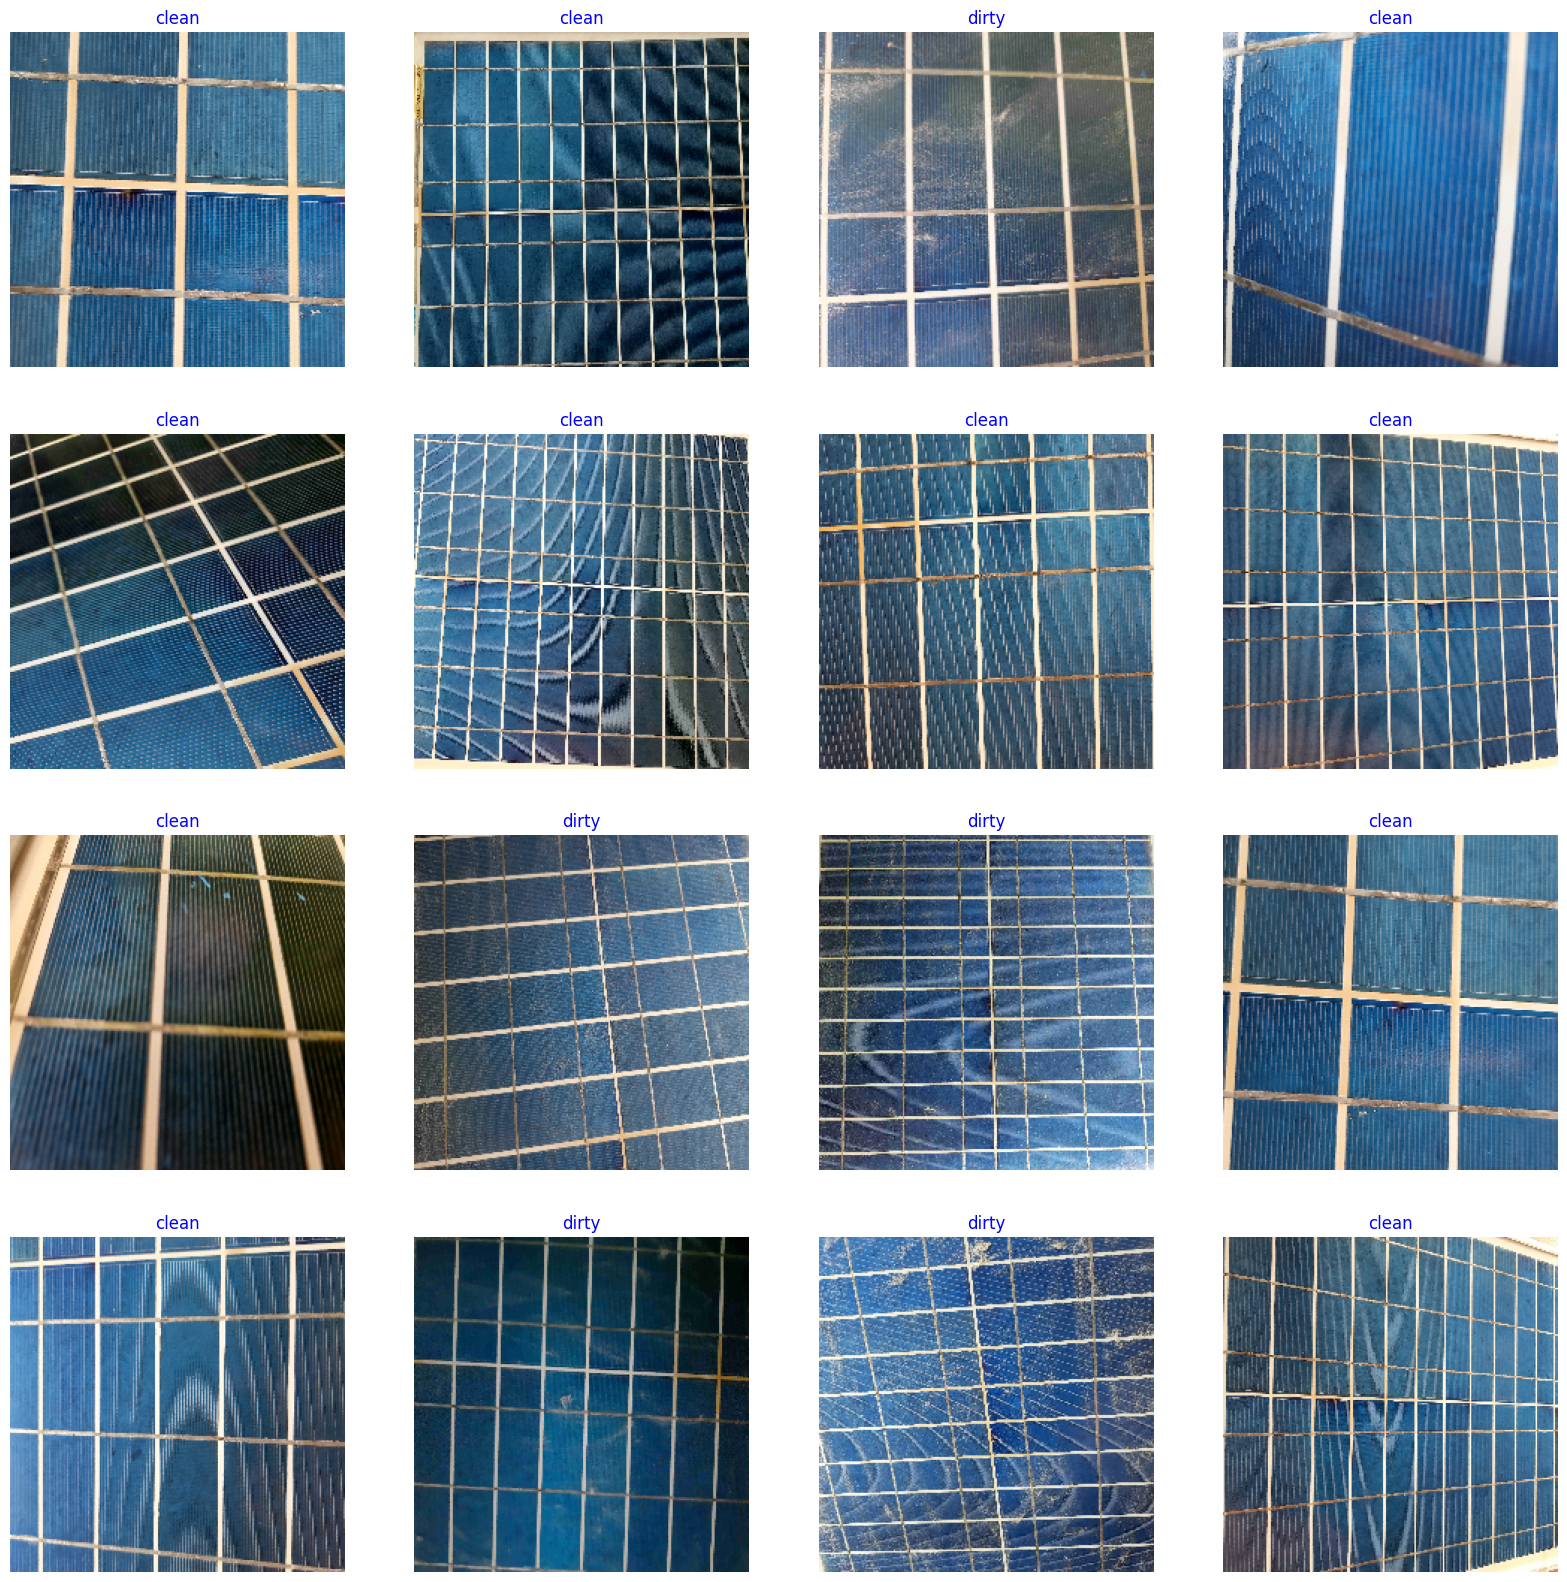

In [16]:
# Visualization
g_dict = train_data.class_indices      
classes = list(g_dict.keys())       
images, labels = next(train_data)

plt.figure(figsize= (20, 20))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

# First transfer learning model (EfficientNetB0)

In [17]:
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)
N_CLASSES = len(list(train_data.class_indices.keys())) 

import tensorflow as tf
from tensorflow.keras.applications.efficientnet import EfficientNetB0

# base model
efficientnet_model = EfficientNetB0(include_top= False, 
                                    weights= "imagenet", 
                                    input_shape= IMG_SHAPE, 
                                    pooling= 'max')
efficientnet_model.trainable = False

inputs = tf.keras.layers.Input(shape=IMG_SHAPE, name="Input_layer")
x = efficientnet_model(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(256, kernel_regularizer= regularizers.l2(l= 0.02), 
          activity_regularizer= regularizers.l1(0.01),
          bias_regularizer= regularizers.l1(0.01), 
          activation= 'relu')(x)
x = Dropout(rate= 0.5, seed= 123)(x)
outputs = tf.keras.layers.Dense(N_CLASSES, activation= 'sigmoid')(x)
efficientnet_tl = tf.keras.Model(inputs=inputs, outputs=outputs)
efficientnet_tl.compile(Adam(learning_rate= 0.001), 
              loss= 'binary_crossentropy', 
              metrics= ['accuracy'])

efficientnet_tl.summary()

16705208/16705208 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                              

In [18]:
batch_size = 20   # set batch size for training
EPOCHS =  20  # number of all epochs in training

efficientnet_tl_history = efficientnet_tl.fit(
    x= train_data, 
    epochs= EPOCHS,
    steps_per_epoch=len(train_data),
    verbose= 1, 
    validation_data= valid_data,
    validation_steps= len(valid_data))

Epoch 1/20


2023-11-27 07:26:14.709356: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


22/22 [==============================] - 123s 5s/step - loss: 8.5145 - accuracy: 0.8113 - val_loss: 6.8759 - val_accuracy: 0.7426
Epoch 2/20
22/22 [==============================] - 88s 4s/step - loss: 5.0237 - accuracy: 0.9495 - val_loss: 3.9129 - val_accuracy: 0.8119
Epoch 3/20
22/22 [==============================] - 90s 4s/step - loss: 2.8747 - accuracy: 0.9733 - val_loss: 2.2441 - val_accuracy: 0.8713
Epoch 4/20
22/22 [==============================] - 79s 4s/step - loss: 1.6969 - accuracy: 0.9703 - val_loss: 1.3893 - val_accuracy: 0.9010
Epoch 5/20
22/22 [==============================] - 88s 4s/step - loss: 1.0992 - accuracy: 0.9703 - val_loss: 0.9454 - val_accuracy: 0.9010
Epoch 6/20
22/22 [==============================] - 79s 4s/step - loss: 0.8109 - accuracy: 0.9688 - val_loss: 0.7395 - val_accuracy: 0.9109
Epoch 7/20
22/22 [==============================] - 79s 4s/step - loss: 0.6217 - accuracy: 0.9762 - val_loss: 0.6283 - val_accuracy: 0.9109
Epoch 8/20
22/22 [============

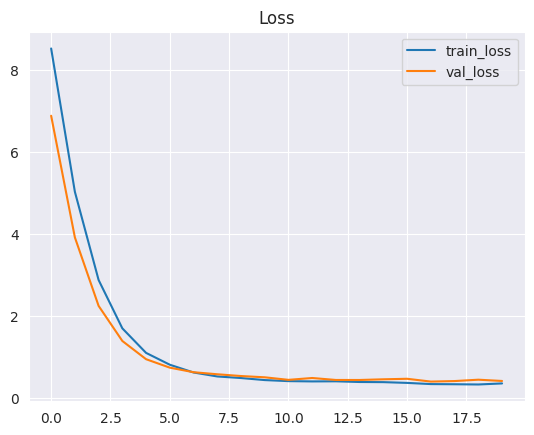

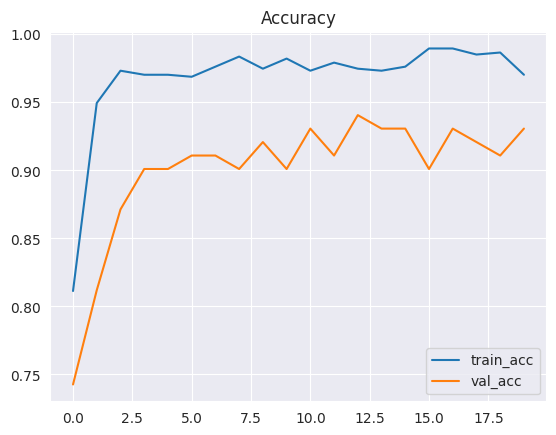

In [19]:
plot_model_evaluation(efficientnet_tl_history)

3/3 [==============================] - 10s 3s/step


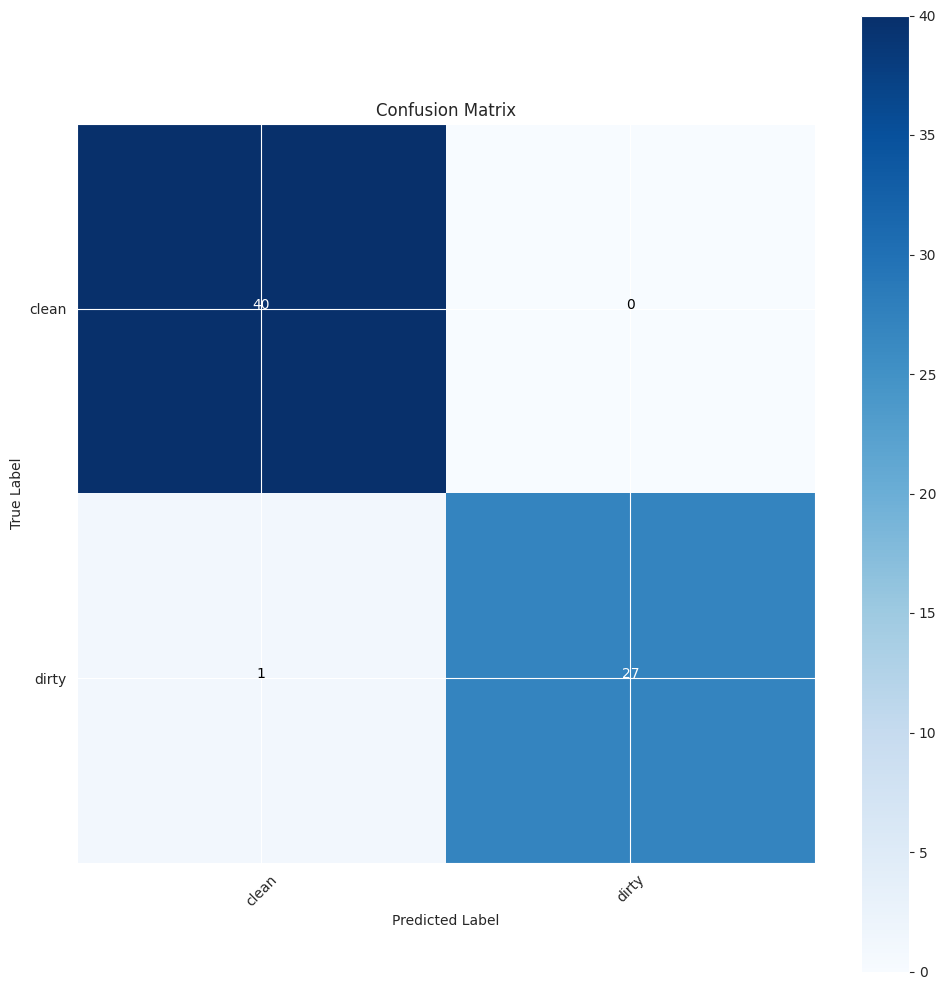

None
              precision    recall  f1-score   support

       clean       0.98      1.00      0.99        40
       dirty       1.00      0.96      0.98        28

    accuracy                           0.99        68
   macro avg       0.99      0.98      0.98        68
weighted avg       0.99      0.99      0.99        68



In [20]:
# Get predictions
classes, efficientnet_tl_y_true, efficientnet_tl_y_pred = get_prediction(efficientnet_tl, 
                                                                       test_data)
# Confusion matrix
print(plot_confusion_matrix(efficientnet_tl_y_true, efficientnet_tl_y_pred, classes))

print(classification_report(efficientnet_tl_y_true, efficientnet_tl_y_pred, target_names= classes))

In [21]:
# Get results to save for later
efficientnet_tl_results = calculate_results(y_true=efficientnet_tl_y_true,
                                            y_pred=efficientnet_tl_y_pred)
efficientnet_tl_results

{'accuracy': 98.52941176470588,
 'precision': 0.9856527977044477,
 'recall': 0.9852941176470589,
 'f1': 0.9852512048590479}

In [22]:
#Save the model
efficientnet_tl.save('efficientnet_tl_solar_dust.h5')


## EfficientNetB0 transfer learning and fine tuning

In [23]:
efficientnet_tl.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514   

In [24]:
# Make all the layers in efficientnet_model trainable
efficientnet_model.trainable = True

efficientnet_base_model = efficientnet_tl.layers[1]
efficientnet_base_model.trainable = True
for layer in efficientnet_base_model.layers[:-10]:
  layer.trainable = False

efficientnet_tl.compile(Adam(learning_rate= 0.0001), 
              loss= 'binary_crossentropy', 
              metrics= ['accuracy'])

efficientnet_tl.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514   

In [25]:
tf.random.set_seed(42)

efficientnet_tl_ft_history = efficientnet_tl.fit(
    train_data,
    epochs=EPOCHS+10,
    initial_epoch=efficientnet_tl_history.epoch[-1],
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data),
)

Epoch 20/30


2023-11-27 07:54:41.407108: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


22/22 [==============================] - 91s 4s/step - loss: 0.3541 - accuracy: 0.9733 - val_loss: 0.3621 - val_accuracy: 0.9265
Epoch 21/30
22/22 [==============================] - 88s 4s/step - loss: 0.3131 - accuracy: 0.9851 - val_loss: 0.3153 - val_accuracy: 0.9706
Epoch 22/30
22/22 [==============================] - 77s 4s/step - loss: 0.3019 - accuracy: 0.9822 - val_loss: 0.3255 - val_accuracy: 0.9412
Epoch 23/30
22/22 [==============================] - 86s 4s/step - loss: 0.3005 - accuracy: 0.9866 - val_loss: 0.2906 - val_accuracy: 0.9853
Epoch 24/30
22/22 [==============================] - 86s 4s/step - loss: 0.2771 - accuracy: 0.9911 - val_loss: 0.2919 - val_accuracy: 0.9706
Epoch 25/30
22/22 [==============================] - 85s 4s/step - loss: 0.2667 - accuracy: 0.9926 - val_loss: 0.2819 - val_accuracy: 0.9706
Epoch 26/30
22/22 [==============================] - 78s 4s/step - loss: 0.2593 - accuracy: 0.9985 - val_loss: 0.2767 - val_accuracy: 0.9706
Epoch 27/30
22/22 [======

20
31
[0.8112927079200745, 0.9494799375534058, 0.9732540845870972, 0.9702823162078857, 0.9702823162078857, 0.96879643201828, 0.9762258529663086, 0.9836552739143372, 0.9747399687767029, 0.9821693897247314, 0.9732540845870972, 0.97919762134552, 0.9747399687767029, 0.9732540845870972, 0.9762258529663086, 0.98959881067276, 0.98959881067276, 0.9851411581039429, 0.9866270422935486, 0.9702823162078857, 0.9732540845870972, 0.9851411581039429, 0.9821693897247314, 0.9866270422935486, 0.9910846948623657, 0.9925705790519714, 0.9985141158103943, 0.9985141158103943, 0.9955423474311829, 0.9970282316207886, 0.9985141158103943]


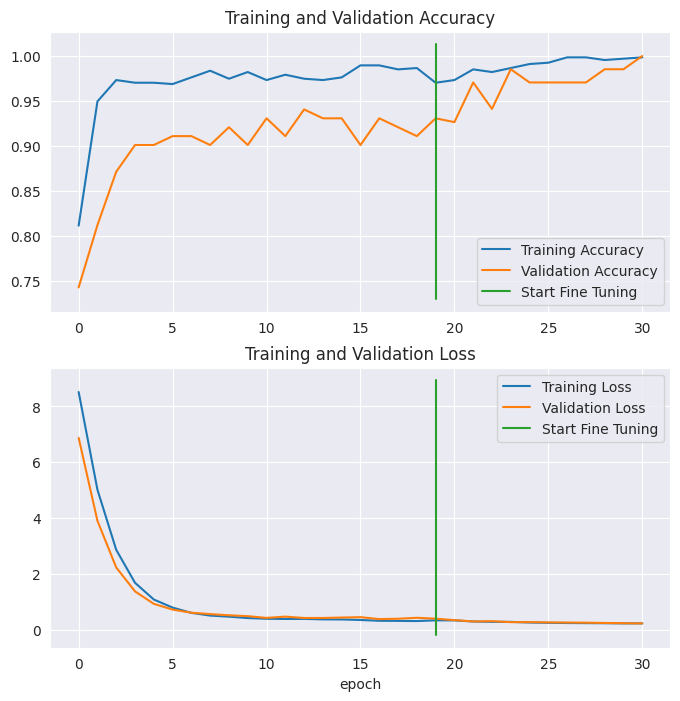

In [26]:
compare_historys(original_history=efficientnet_tl_history,
                 new_history=efficientnet_tl_ft_history,
                 initial_epochs=20)

3/3 [==============================] - 8s 2s/step


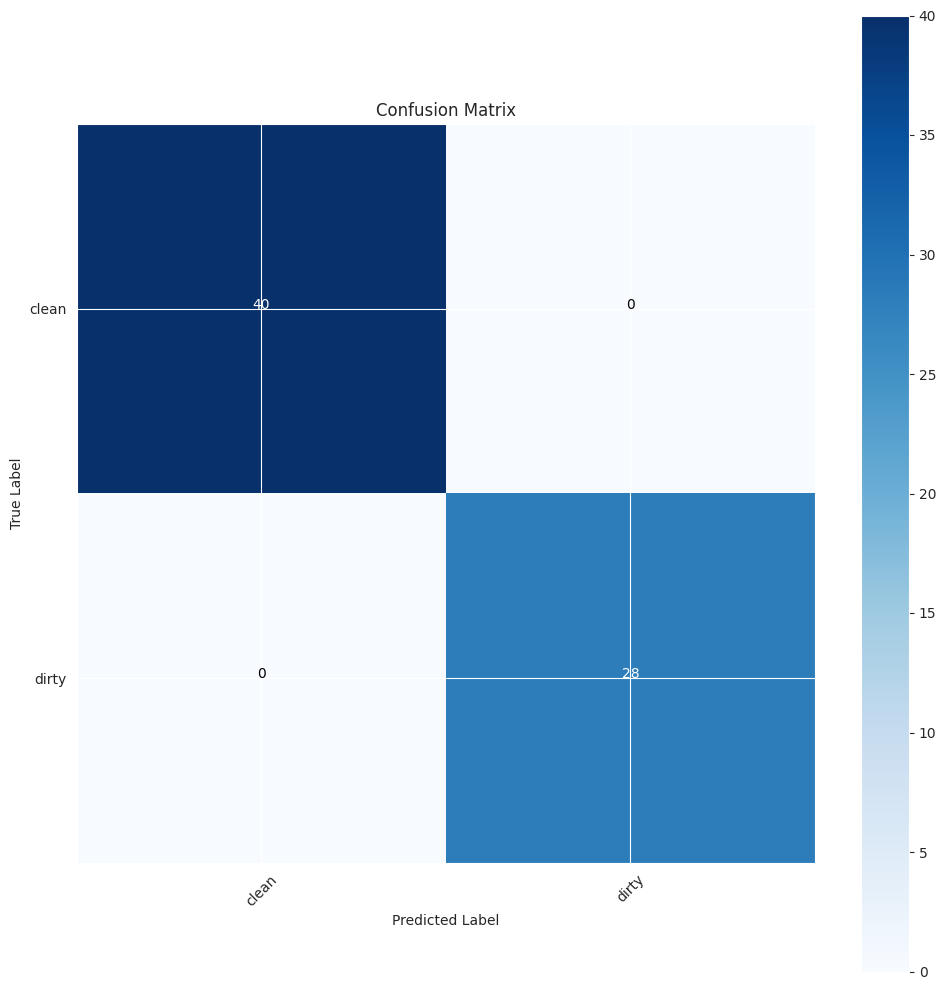

None
              precision    recall  f1-score   support

       clean       1.00      1.00      1.00        40
       dirty       1.00      1.00      1.00        28

    accuracy                           1.00        68
   macro avg       1.00      1.00      1.00        68
weighted avg       1.00      1.00      1.00        68



In [27]:
# Get predictions
classes, efficientnet_tl_ft_y_true, efficientnet_tl_ft_y_pred = get_prediction(efficientnet_tl, 
                                                                       test_data)
# Confusion matrix
print(plot_confusion_matrix(efficientnet_tl_ft_y_true, efficientnet_tl_ft_y_pred, classes))

print(classification_report(efficientnet_tl_ft_y_true, efficientnet_tl_ft_y_pred, target_names= classes))

In [28]:
# Evaluate the fine tuned model
test_len = len(test_df)
test_batch_size = max(sorted([test_len // n for n in range(1, test_len + 1) if test_len%n == 0 and test_len/n <= 80]))
test_steps = test_len // test_batch_size

efficientnet_tl_ft_train_score = efficientnet_tl.evaluate(train_data,
                                                             steps= test_steps, 
                                                             verbose= 1)
efficientnet_tl_ft_valid_score = efficientnet_tl.evaluate(valid_data,
                                                             steps= test_steps, 
                                                             verbose= 1)
efficientnet_tl_ft_test_score = efficientnet_tl.evaluate(test_data, 
                                                            steps= test_steps, 
                                                            verbose= 1)

print("Train Loss: ", efficientnet_tl_ft_train_score[0])
print("Train Accuracy: ", efficientnet_tl_ft_train_score[1])
print('-' * 20)
print("Validation Loss: ", efficientnet_tl_ft_valid_score[0])
print("Validation Accuracy: ", efficientnet_tl_ft_valid_score[1])
print('-' * 20)
print("Test Loss: ", efficientnet_tl_ft_test_score[0])
print("Test Accuracy: ", efficientnet_tl_ft_test_score[1])

1/1 [==============================] - 3s 3s/step - loss: 0.2593 - accuracy: 1.0000
Train Loss:  0.2120407223701477
Train Accuracy:  1.0
--------------------
Validation Loss:  0.2790091633796692
Validation Accuracy:  0.96875
--------------------
Test Loss:  0.25933706760406494
Test Accuracy:  1.0


In [29]:
# Get results to save for later
efficientnet_tl_ft_results = calculate_results(y_true=efficientnet_tl_ft_y_true, 
                                               y_pred=efficientnet_tl_ft_y_pred)
efficientnet_tl_ft_results

{'accuracy': 100.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}

In [30]:
#Save the model
efficientnet_tl.save('efficientnet_tl_ft_solar_dust.h5')

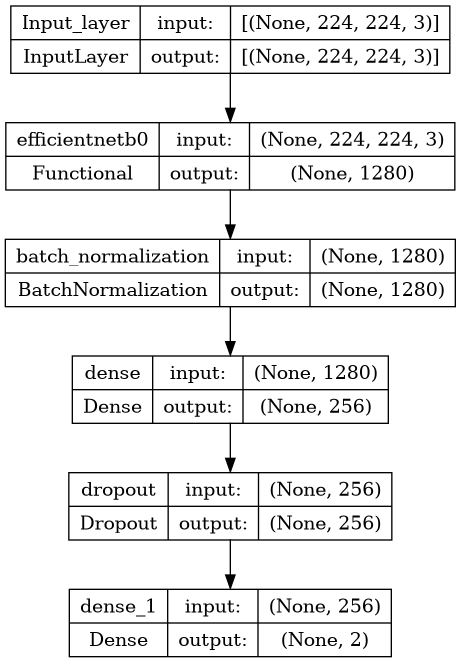

In [31]:
plot_model(efficientnet_tl,show_layer_names=(True),show_shapes=(True))

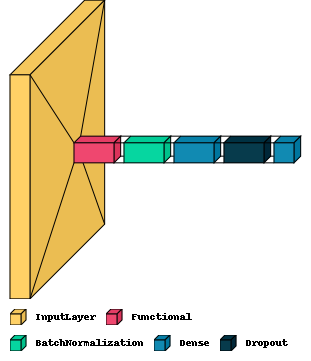

In [32]:
visualkeras.layered_view(efficientnet_tl, legend=True, scale_xy=1, scale_z=2, max_z=40)

# Second transfer learning model (VGG16)

In [33]:
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)
N_CLASSES = len(list(train_data.class_indices.keys())) 

import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16

# Create a base model for VGG16
vgg16_model = VGG16(
    input_shape=IMG_SHAPE,
    weights= "imagenet",
    include_top=False,
    pooling= 'max'
)

# Freeze the base model first to do feature extraction 
vgg16_model.trainable = False

inputs = tf.keras.layers.Input(shape=IMG_SHAPE, name="Input_layer")
x = vgg16_model(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(256, kernel_regularizer= regularizers.l2(l=0.02), 
          activity_regularizer= regularizers.l1(0.01),
          bias_regularizer= regularizers.l1(0.01), 
          activation= 'relu')(x)
x = Dropout(rate= 0.5, seed= 123)(x)
outputs = tf.keras.layers.Dense(N_CLASSES, activation= 'sigmoid')(x)
vgg16_tl = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
vgg16_tl.compile(Adam(learning_rate= 0.001), 
              loss= 'binary_crossentropy', 
              metrics= ['accuracy'])

vgg16_tl.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 514  

In [34]:
batch_size = 20   # set batch size for training
EPOCHS =  20  # number of all epochs in training

vgg16_tl_history = vgg16_tl.fit(
    x= train_data, 
    epochs= EPOCHS,
    steps_per_epoch=len(train_data),
    verbose= 1, 
    validation_data= valid_data,
    validation_steps= len(valid_data))

Epoch 1/20
22/22 [==============================] - 96s 4s/step - loss: 7.2253 - accuracy: 0.7340 - val_loss: 7.6350 - val_accuracy: 0.6634
Epoch 2/20
22/22 [==============================] - 80s 4s/step - loss: 4.6293 - accuracy: 0.9153 - val_loss: 4.2149 - val_accuracy: 0.8317
Epoch 3/20
22/22 [==============================] - 73s 3s/step - loss: 2.8958 - accuracy: 0.9599 - val_loss: 2.5574 - val_accuracy: 0.8614
Epoch 4/20
22/22 [==============================] - 73s 3s/step - loss: 1.8723 - accuracy: 0.9554 - val_loss: 1.6301 - val_accuracy: 0.8911
Epoch 5/20
22/22 [==============================] - 78s 4s/step - loss: 1.2401 - accuracy: 0.9747 - val_loss: 1.1410 - val_accuracy: 0.8911
Epoch 6/20
22/22 [==============================] - 73s 3s/step - loss: 0.8781 - accuracy: 0.9762 - val_loss: 0.8377 - val_accuracy: 0.9208
Epoch 7/20
22/22 [==============================] - 76s 3s/step - loss: 0.6756 - accuracy: 0.9866 - val_loss: 0.6722 - val_accuracy: 0.9406
Epoch 8/20
22/22 [==

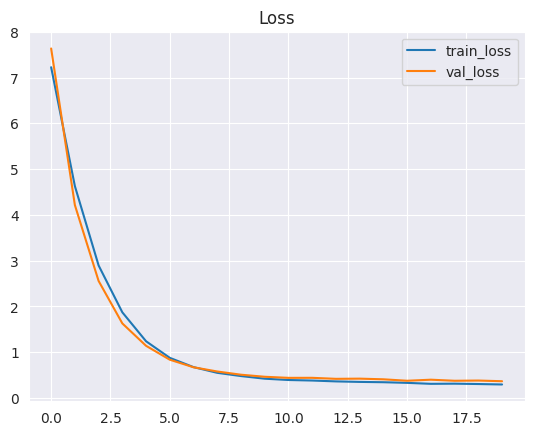

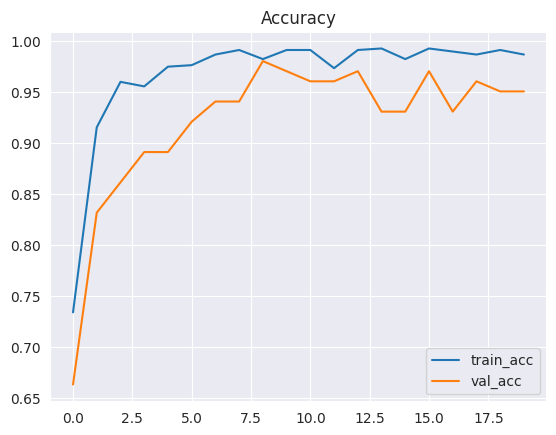

In [35]:
plot_model_evaluation(vgg16_tl_history)

3/3 [==============================] - 7s 2s/step


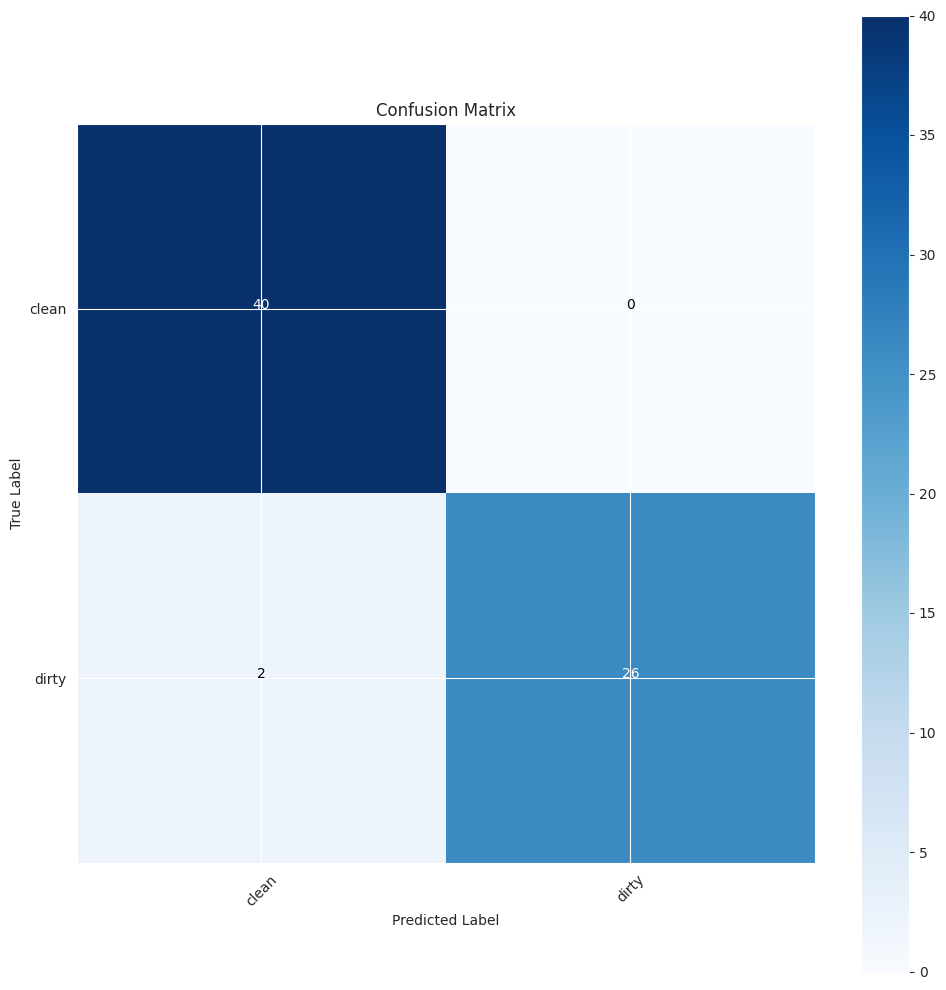

None
              precision    recall  f1-score   support

       clean       0.95      1.00      0.98        40
       dirty       1.00      0.93      0.96        28

    accuracy                           0.97        68
   macro avg       0.98      0.96      0.97        68
weighted avg       0.97      0.97      0.97        68



In [36]:
# Get predictions
classes, vgg16_tl_y_true, vgg16_tl_y_pred = get_prediction(vgg16_tl,
                                                           test_data)
# Confusion matrix
print(plot_confusion_matrix(vgg16_tl_y_true, 
                            vgg16_tl_y_pred, 
                            classes))

print(classification_report(vgg16_tl_y_true, 
                            vgg16_tl_y_pred, 
                            target_names= classes))

In [37]:
# Get results to save for later
vgg16_tl_results = calculate_results(y_true=vgg16_tl_y_true,
                                     y_pred=vgg16_tl_y_pred)
vgg16_tl_results

{'accuracy': 97.05882352941177,
 'precision': 0.9719887955182074,
 'recall': 0.9705882352941176,
 'f1': 0.9704022530421383}

In [38]:
# Save the model
vgg16_tl.save('vgg16_tl_solar_dust.h5')

## VGG16 transfer learning and fine tuning

In [39]:
vgg16_tl.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 514       
                                                           

In [40]:
# Make all the layers in efficientnet_model trainable
vgg16_model.trainable = True

vgg16_base_model = vgg16_tl.layers[1]
vgg16_base_model.trainable = True
for layer in vgg16_base_model.layers[:-10]:
  layer.trainable = False

vgg16_tl.compile(Adam(learning_rate= 0.0001), 
              loss= 'binary_crossentropy', 
              metrics= ['accuracy'])

vgg16_tl.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 514       
                                                           

In [41]:
tf.random.set_seed(42)

vgg16_tl_ft_history = vgg16_tl.fit(
    train_data,
    epochs=EPOCHS+10,
    initial_epoch=vgg16_tl_history.epoch[-1],
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data),
)

Epoch 20/30
22/22 [==============================] - 97s 4s/step - loss: 0.3453 - accuracy: 0.9510 - val_loss: 2.3034 - val_accuracy: 0.5882
Epoch 21/30
22/22 [==============================] - 81s 4s/step - loss: 0.3122 - accuracy: 0.9673 - val_loss: 3.4363 - val_accuracy: 0.5882
Epoch 22/30
22/22 [==============================] - 77s 3s/step - loss: 0.2874 - accuracy: 0.9792 - val_loss: 0.3870 - val_accuracy: 0.9559
Epoch 23/30
22/22 [==============================] - 69s 3s/step - loss: 0.2594 - accuracy: 0.9896 - val_loss: 0.4258 - val_accuracy: 0.9559
Epoch 24/30
22/22 [==============================] - 71s 3s/step - loss: 0.2554 - accuracy: 0.9911 - val_loss: 0.4218 - val_accuracy: 0.9265
Epoch 25/30
22/22 [==============================] - 70s 3s/step - loss: 0.2435 - accuracy: 0.9941 - val_loss: 0.4166 - val_accuracy: 0.9412
Epoch 26/30
22/22 [==============================] - 70s 3s/step - loss: 0.2480 - accuracy: 0.9881 - val_loss: 0.2760 - val_accuracy: 0.9853
Epoch 27/30
2

20
31
[0.7340267300605774, 0.9153046011924744, 0.9598811268806458, 0.9554234743118286, 0.9747399687767029, 0.9762258529663086, 0.9866270422935486, 0.9910846948623657, 0.9821693897247314, 0.9910846948623657, 0.9910846948623657, 0.9732540845870972, 0.9910846948623657, 0.9925705790519714, 0.9821693897247314, 0.9925705790519714, 0.98959881067276, 0.9866270422935486, 0.9910846948623657, 0.9866270422935486, 0.9509658217430115, 0.9673105478286743, 0.97919762134552, 0.98959881067276, 0.9910846948623657, 0.9940564632415771, 0.9881129264831543, 0.9970282316207886, 1.0, 0.9985141158103943, 0.9985141158103943]


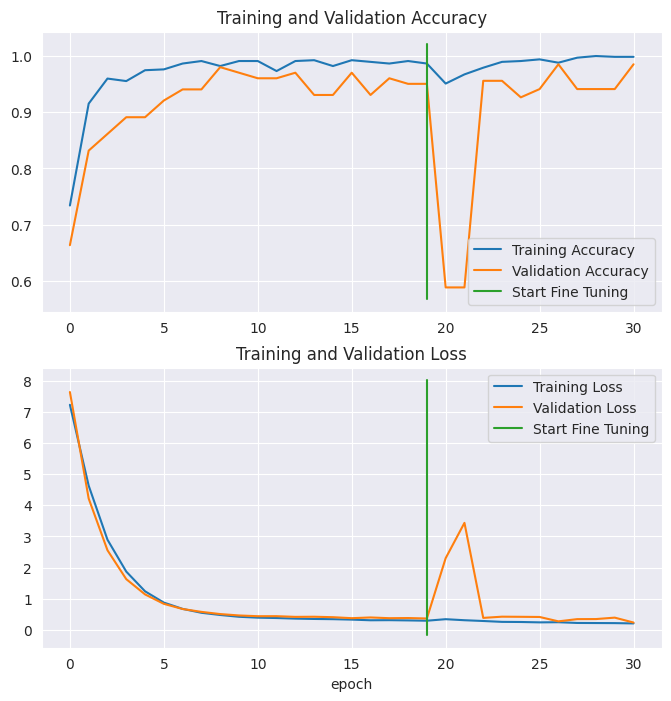

In [42]:
compare_historys(original_history=vgg16_tl_history,
                 new_history=vgg16_tl_ft_history,
                 initial_epochs=20)

3/3 [==============================] - 7s 2s/step


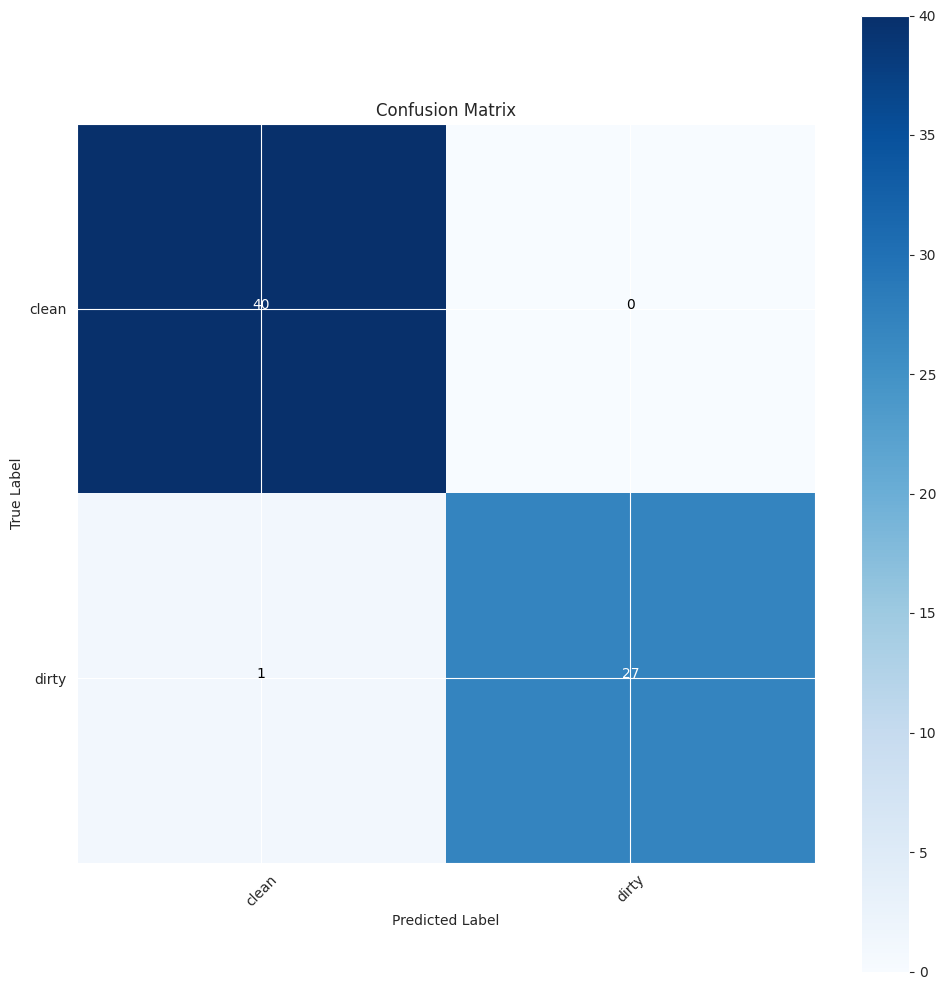

None
              precision    recall  f1-score   support

       clean       0.98      1.00      0.99        40
       dirty       1.00      0.96      0.98        28

    accuracy                           0.99        68
   macro avg       0.99      0.98      0.98        68
weighted avg       0.99      0.99      0.99        68



In [43]:
# Get predictions
classes, vgg16_tl_ft_y_true, vgg16_tl_ft_y_pred = get_prediction(vgg16_tl,
                                                           test_data)
# Confusion matrix
print(plot_confusion_matrix(vgg16_tl_ft_y_true, 
                            vgg16_tl_ft_y_pred, 
                            classes))

print(classification_report(vgg16_tl_ft_y_true, 
                            vgg16_tl_ft_y_pred, 
                            target_names= classes))

In [44]:
# Evaluate the fine tuned model
test_len = len(test_df)
test_batch_size = max(sorted([test_len // n for n in range(1, test_len + 1) if test_len%n == 0 and test_len/n <= 80]))
test_steps = test_len // test_batch_size

vgg16_tl_ft_train_score = vgg16_tl.evaluate(train_data,
                                            steps= test_steps,
                                            verbose= 1)
vgg16_tl_ft_valid_score = vgg16_tl.evaluate(valid_data,
                                            steps= test_steps,
                                            verbose= 1)
vgg16_tl_ft_test_score = vgg16_tl.evaluate(test_data, 
                                           steps= test_steps, 
                                           verbose= 1)

print("Train Loss: ", vgg16_tl_ft_train_score[0])
print("Train Accuracy: ", vgg16_tl_ft_train_score[1])
print('-' * 20)
print("Validation Loss: ", vgg16_tl_ft_valid_score[0])
print("Validation Accuracy: ", vgg16_tl_ft_valid_score[1])
print('-' * 20)
print("Test Loss: ", vgg16_tl_ft_test_score[0])
print("Test Accuracy: ", vgg16_tl_ft_test_score[1])

1/1 [==============================] - 3s 3s/step - loss: 0.2405 - accuracy: 0.9688
Train Loss:  0.2238166630268097
Train Accuracy:  1.0
--------------------
Validation Loss:  0.2952847480773926
Validation Accuracy:  0.96875
--------------------
Test Loss:  0.24047276377677917
Test Accuracy:  0.96875


In [45]:
# Get results to save for later
vgg16_tl_ft_results = calculate_results(y_true=vgg16_tl_ft_y_true,
                                        y_pred=vgg16_tl_ft_y_pred)
vgg16_tl_ft_results

{'accuracy': 98.52941176470588,
 'precision': 0.9856527977044477,
 'recall': 0.9852941176470589,
 'f1': 0.9852512048590479}

In [46]:
# Save the model
vgg16_tl.save('vgg16_tl_ft_solar_dust.h5')

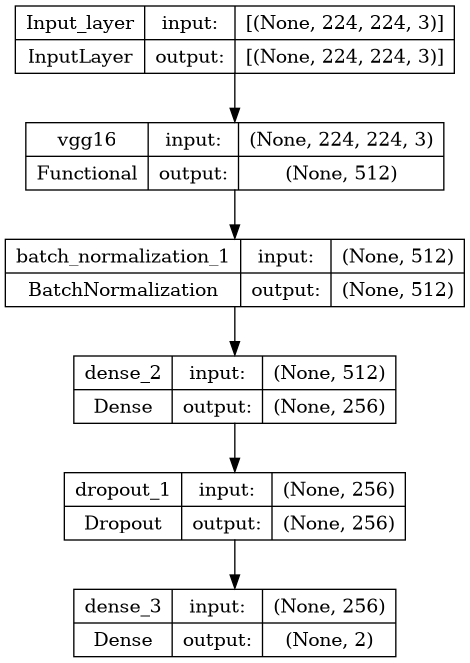

In [47]:
plot_model(vgg16_tl,show_layer_names=(True),show_shapes=(True))

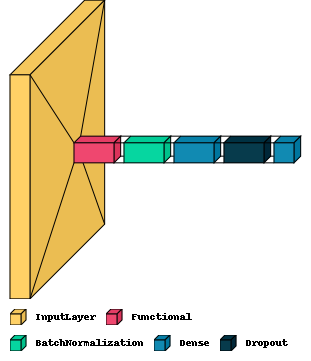

In [48]:
visualkeras.layered_view(vgg16_tl, legend=True, scale_xy=1, scale_z=2, max_z=40)

# Third transfer learning model (ResNet50)

In [49]:
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)
N_CLASSES = len(list(train_data.class_indices.keys())) 

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50

# Create a base model for ResNet50
resnet50_model = ResNet50(
    input_shape=IMG_SHAPE,
    weights= "imagenet",
    include_top=False,
    pooling= 'max'
)

# Freeze the base model first to do feature extraction
resnet50_model.trainable = False

inputs = tf.keras.layers.Input(shape=IMG_SHAPE, name="Input_layer")
x = resnet50_model(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(256, kernel_regularizer= regularizers.l2(l= 0.02), 
          activity_regularizer= regularizers.l1(0.01),
          bias_regularizer= regularizers.l1(0.01), 
          activation= 'relu')(x)
x = Dropout(rate= 0.5, seed= 123)(x)
outputs = tf.keras.layers.Dense(N_CLASSES, activation= 'sigmoid')(x)
resnet50_tl = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
resnet50_tl.compile(Adam(learning_rate= 0.001), 
              loss= 'binary_crossentropy', 
              metrics= ['accuracy'])

resnet50_tl.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 batch_normalization_2 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 256)               524544    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 2)                 514  

In [51]:
batch_size = 20   # set batch size for training
EPOCHS =  20  # number of all epochs in training

resnet50_tl_history = resnet50_tl.fit(
    x= train_data, 
    epochs= EPOCHS,
    steps_per_epoch=len(train_data),
    verbose= 1, 
    validation_data= valid_data,
    validation_steps= len(valid_data))

Epoch 1/20
22/22 [==============================] - 89s 4s/step - loss: 8.9558 - accuracy: 0.8871 - val_loss: 7.5373 - val_accuracy: 0.9406
Epoch 2/20
22/22 [==============================] - 74s 3s/step - loss: 4.9326 - accuracy: 0.9747 - val_loss: 3.7089 - val_accuracy: 0.9703
Epoch 3/20
22/22 [==============================] - 85s 4s/step - loss: 2.6641 - accuracy: 0.9881 - val_loss: 2.0121 - val_accuracy: 0.9604
Epoch 4/20
22/22 [==============================] - 76s 3s/step - loss: 1.4432 - accuracy: 0.9970 - val_loss: 1.1412 - val_accuracy: 0.9802
Epoch 5/20
22/22 [==============================] - 81s 4s/step - loss: 0.8999 - accuracy: 0.9955 - val_loss: 0.7865 - val_accuracy: 0.9802
Epoch 6/20
22/22 [==============================] - 84s 4s/step - loss: 0.6413 - accuracy: 0.9941 - val_loss: 0.5912 - val_accuracy: 0.9703
Epoch 7/20
22/22 [==============================] - 86s 4s/step - loss: 0.5163 - accuracy: 0.9941 - val_loss: 0.4832 - val_accuracy: 0.9901
Epoch 8/20
22/22 [==

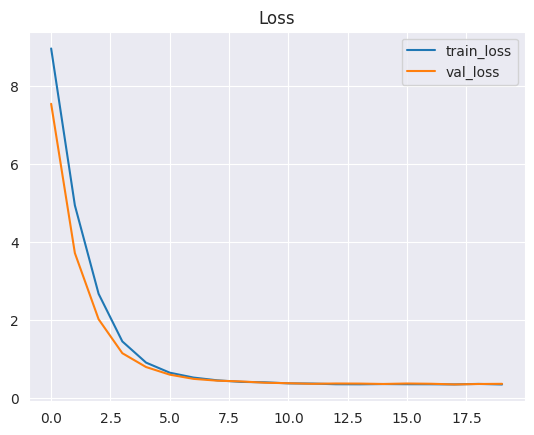

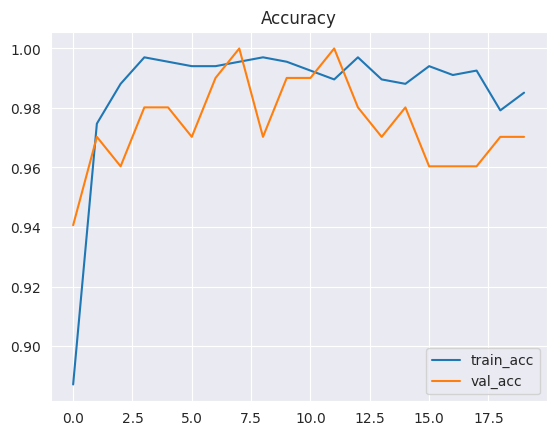

In [52]:
plot_model_evaluation(resnet50_tl_history)

3/3 [==============================] - 8s 2s/step


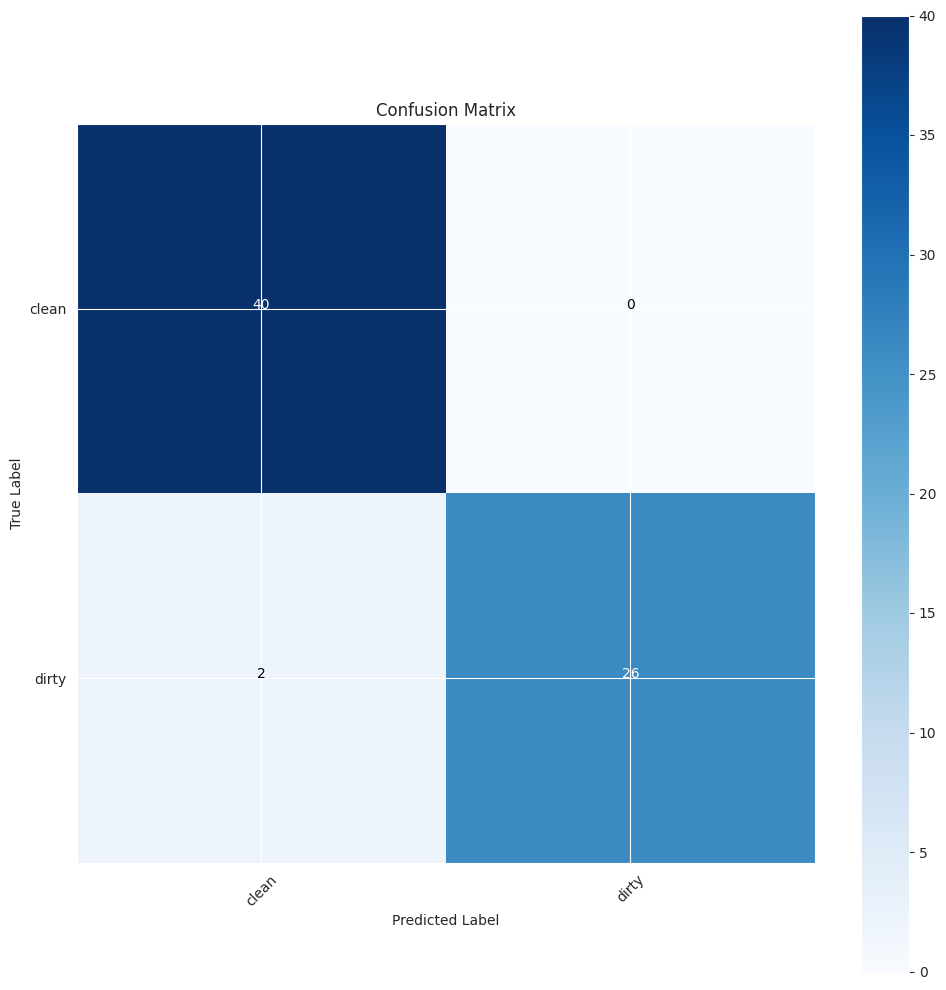

None
              precision    recall  f1-score   support

       clean       0.95      1.00      0.98        40
       dirty       1.00      0.93      0.96        28

    accuracy                           0.97        68
   macro avg       0.98      0.96      0.97        68
weighted avg       0.97      0.97      0.97        68



In [53]:
# Get predictions
classes, resnet50_tl_y_true, resnet50_tl_y_pred = get_prediction(resnet50_tl,
                                                                 test_data)
# Confusion matrix
print(plot_confusion_matrix(resnet50_tl_y_true, 
                            resnet50_tl_y_pred, 
                            classes))

print(classification_report(resnet50_tl_y_true, 
                            resnet50_tl_y_pred, 
                            target_names= classes))

In [54]:
# Get results to save for later
resnet50_tl_results = calculate_results(y_true=resnet50_tl_y_true,
                                        y_pred=resnet50_tl_y_pred)
resnet50_tl_results

{'accuracy': 97.05882352941177,
 'precision': 0.9719887955182074,
 'recall': 0.9705882352941176,
 'f1': 0.9704022530421383}

In [55]:
#S ave the model
resnet50_tl.save('resnet50_tl_ft_solar_dust.h5')

## ResNet50 transfer learning and fine tuning

In [56]:
resnet50_tl.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 batch_normalization_2 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 256)               524544    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 2)                 514       
                                                           

In [57]:
# Make all the layers in efficientnet_model trainable
resnet50_model.trainable = True

resnet50_base_model = resnet50_tl.layers[1]
resnet50_base_model.trainable = True
for layer in resnet50_base_model.layers[:-10]:
  layer.trainable = False

resnet50_tl.compile(Adam(learning_rate= 0.0001), 
              loss= 'binary_crossentropy', 
              metrics= ['accuracy'])

resnet50_tl.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 batch_normalization_2 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 256)               524544    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 2)                 514       
                                                           

In [58]:
tf.random.set_seed(42)

resnet50_tl_ft_history = resnet50_tl.fit(
    train_data,
    epochs=EPOCHS+10,
    initial_epoch=resnet50_tl_history.epoch[-1],
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data),
)

Epoch 20/30
22/22 [==============================] - 80s 3s/step - loss: 0.3525 - accuracy: 0.9777 - val_loss: 0.3239 - val_accuracy: 0.9706
Epoch 21/30
22/22 [==============================] - 73s 3s/step - loss: 0.2874 - accuracy: 0.9941 - val_loss: 0.3178 - val_accuracy: 0.9559
Epoch 22/30
22/22 [==============================] - 70s 3s/step - loss: 0.2755 - accuracy: 0.9985 - val_loss: 0.2929 - val_accuracy: 0.9559
Epoch 23/30
22/22 [==============================] - 71s 3s/step - loss: 0.2699 - accuracy: 0.9970 - val_loss: 0.2823 - val_accuracy: 0.9559
Epoch 24/30
22/22 [==============================] - 70s 3s/step - loss: 0.2609 - accuracy: 0.9955 - val_loss: 0.2733 - val_accuracy: 0.9706
Epoch 25/30
22/22 [==============================] - 71s 3s/step - loss: 0.2476 - accuracy: 0.9985 - val_loss: 0.2646 - val_accuracy: 0.9559
Epoch 26/30
22/22 [==============================] - 70s 3s/step - loss: 0.2444 - accuracy: 0.9985 - val_loss: 0.2595 - val_accuracy: 0.9706
Epoch 27/30
2

20
31
[0.8870728015899658, 0.9747399687767029, 0.9881129264831543, 0.9970282316207886, 0.9955423474311829, 0.9940564632415771, 0.9940564632415771, 0.9955423474311829, 0.9970282316207886, 0.9955423474311829, 0.9925705790519714, 0.98959881067276, 0.9970282316207886, 0.98959881067276, 0.9881129264831543, 0.9940564632415771, 0.9910846948623657, 0.9925705790519714, 0.97919762134552, 0.9851411581039429, 0.9777117371559143, 0.9940564632415771, 0.9985141158103943, 0.9970282316207886, 0.9955423474311829, 0.9985141158103943, 0.9985141158103943, 0.9985141158103943, 1.0, 0.9985141158103943, 0.9985141158103943]


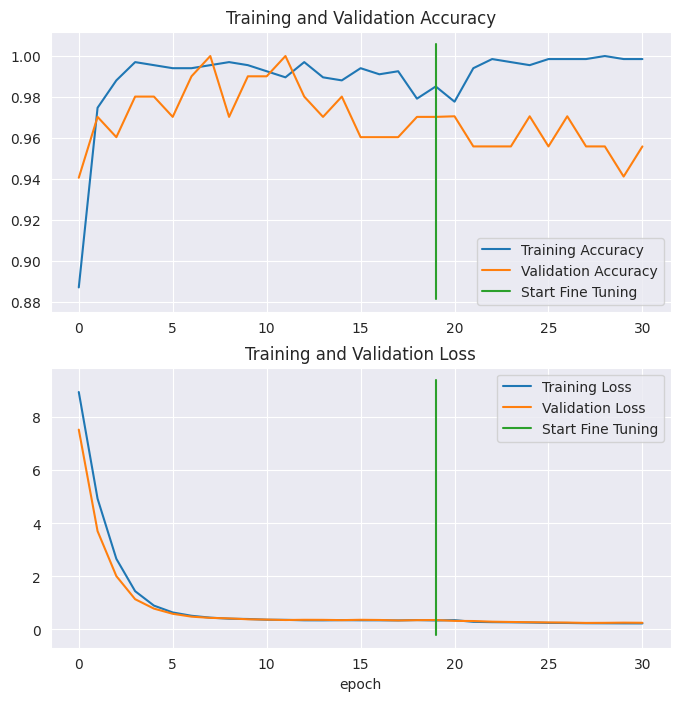

In [59]:
compare_historys(original_history=resnet50_tl_history,
                 new_history=resnet50_tl_ft_history,
                 initial_epochs=20)

3/3 [==============================] - 7s 2s/step


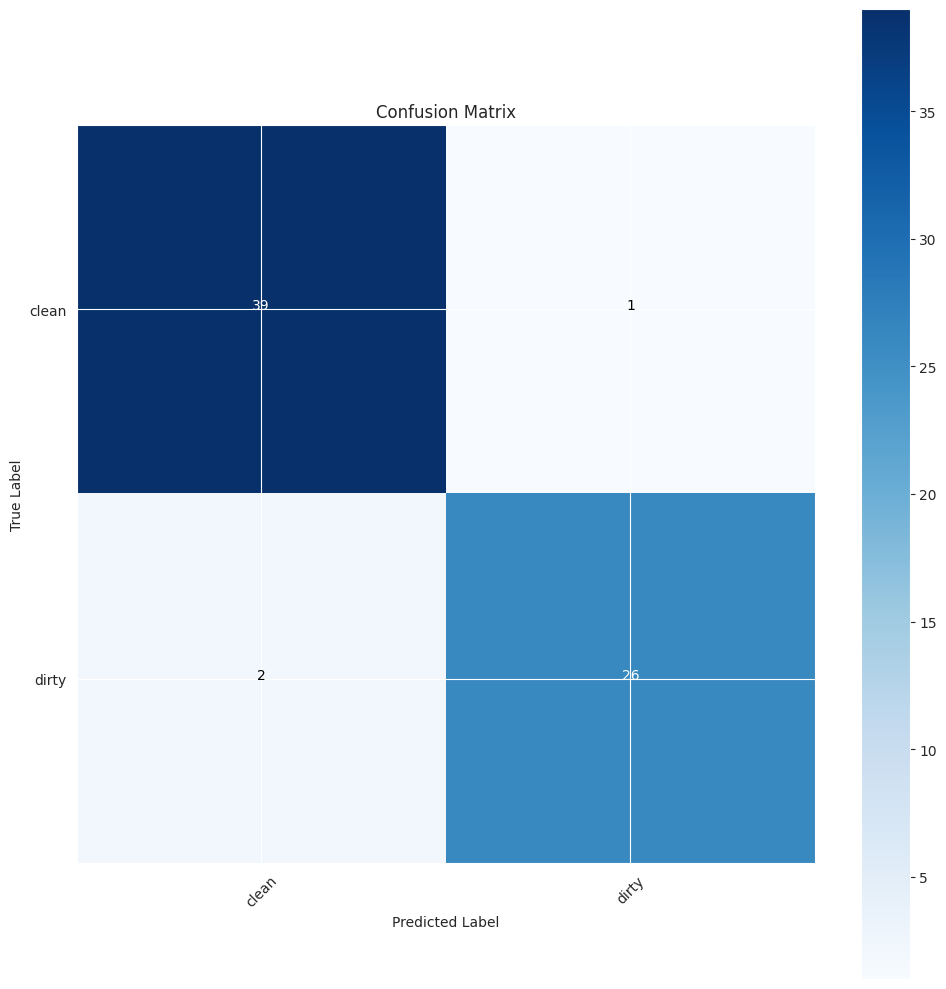

None
              precision    recall  f1-score   support

       clean       0.95      0.97      0.96        40
       dirty       0.96      0.93      0.95        28

    accuracy                           0.96        68
   macro avg       0.96      0.95      0.95        68
weighted avg       0.96      0.96      0.96        68



In [60]:
# Get predictions
classes, resnet50_tl_ft_y_true, resnet50_tl_ft_y_pred = get_prediction(resnet50_tl,
                                                                       test_data)
# Confusion matrix
print(plot_confusion_matrix(resnet50_tl_ft_y_true, 
                            resnet50_tl_ft_y_pred, 
                            classes))

print(classification_report(resnet50_tl_ft_y_true, 
                            resnet50_tl_ft_y_pred, 
                            target_names= classes))

In [61]:
# Evaluate the fine tuned model
test_len = len(test_df)
test_batch_size = max(sorted([test_len // n for n in range(1, test_len + 1) if test_len%n == 0 and test_len/n <= 80]))
test_steps = test_len // test_batch_size

resnet50_tl_ft_train_score = resnet50_tl.evaluate(train_data,
                                                  steps= test_steps,
                                                  verbose= 1)
resnet50_tl_ft_valid_score = resnet50_tl.evaluate(valid_data,
                                                  steps= test_steps, 
                                                  verbose= 1)
resnet50_tl_ft_test_score = resnet50_tl.evaluate(test_data, 
                                                 steps= test_steps, 
                                                 verbose= 1)

print("Train Loss: ", resnet50_tl_ft_train_score[0])
print("Train Accuracy: ", resnet50_tl_ft_train_score[1])
print('-' * 20)
print("Validation Loss: ", resnet50_tl_ft_valid_score[0])
print("Validation Accuracy: ", resnet50_tl_ft_valid_score[1])
print('-' * 20)
print("Test Loss: ", resnet50_tl_ft_test_score[0])
print("Test Accuracy: ", resnet50_tl_ft_test_score[1])

1/1 [==============================] - 4s 4s/step - loss: 0.2539 - accuracy: 0.9688
Train Loss:  0.19713684916496277
Train Accuracy:  1.0
--------------------
Validation Loss:  0.2484302520751953
Validation Accuracy:  1.0
--------------------
Test Loss:  0.25391751527786255
Test Accuracy:  0.96875


In [62]:
# Get results to save for later
resnet50_tl_ft_results = calculate_results(y_true=resnet50_tl_ft_y_true,
                                           y_pred=resnet50_tl_ft_y_pred)
resnet50_tl_ft_results

{'accuracy': 95.58823529411765,
 'precision': 0.9560550507465858,
 'recall': 0.9558823529411765,
 'f1': 0.9557536145771439}

In [63]:
# Save the model
resnet50_tl.save('resnet50_tl_ft_solar_dust.h5')

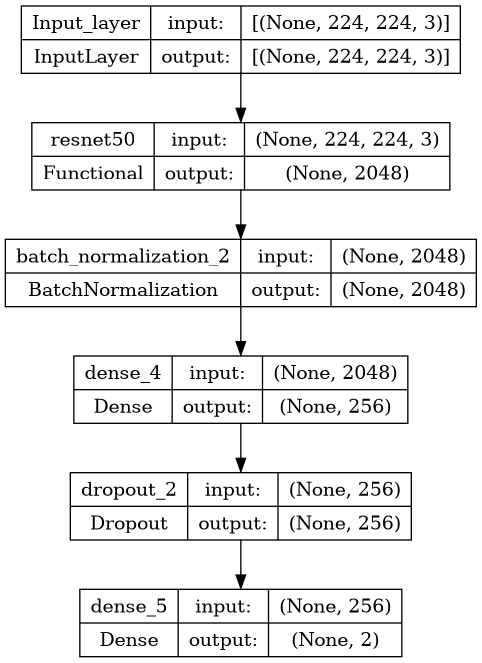

In [64]:
plot_model(resnet50_tl,show_layer_names=(True),show_shapes=(True))

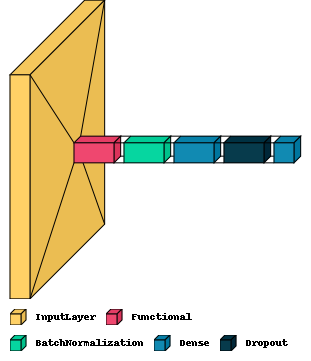

In [65]:
visualkeras.layered_view(resnet50_tl, legend=True, scale_xy=1, scale_z=2, max_z=40)

# Comparing performance of all models

In [66]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"EfficientNet_TL": efficientnet_tl_results,
                                  "EfficientNet_TL_FT": efficientnet_tl_ft_results,
                                  "VGG16_TL": vgg16_tl_results,
                                  "VGG16_TL_FT": vgg16_tl_ft_results,
                                  "ResNet50_TL": resnet50_tl_results,
                                  "ResNet50_TL_FT": resnet50_tl_ft_results})
all_model_results = all_model_results.transpose()
all_model_results

accuracy  precision    recall        f1
EfficientNet_TL      98.529412   0.985653  0.985294  0.985251
EfficientNet_TL_FT  100.000000   1.000000  1.000000  1.000000
VGG16_TL             97.058824   0.971989  0.970588  0.970402
VGG16_TL_FT          98.529412   0.985653  0.985294  0.985251
ResNet50_TL          97.058824   0.971989  0.970588  0.970402
ResNet50_TL_FT       95.588235   0.956055  0.955882  0.955754

In [67]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results

accuracy  precision    recall        f1
EfficientNet_TL     0.985294   0.985653  0.985294  0.985251
EfficientNet_TL_FT  1.000000   1.000000  1.000000  1.000000
VGG16_TL            0.970588   0.971989  0.970588  0.970402
VGG16_TL_FT         0.985294   0.985653  0.985294  0.985251
ResNet50_TL         0.970588   0.971989  0.970588  0.970402
ResNet50_TL_FT      0.955882   0.956055  0.955882  0.955754

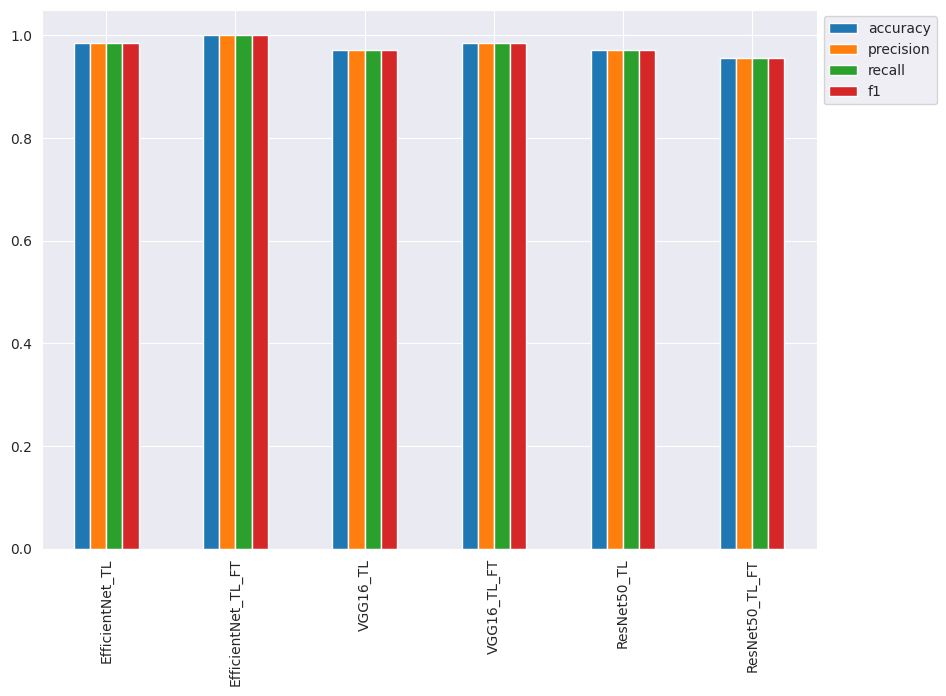

In [68]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

Conclusion: VGG16 model with transfer learning and fine tuning getting 100% accuracy in predicting the cleanness of solar photovoltaics panel. 

# Download the best model (`efficientnet_tl_ft`) to be deployed on Streamlit WebApp

In [69]:
model_json = efficientnet_tl.to_json()
with open("best_model.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
efficientnet_tl.save_weights("best_model.h5")
print("Saved model to disk")

Saved model to disk


# Test the best model (`efficientnet_tl_ft`)

In [70]:
from tensorflow.keras.models import model_from_json
# load json and create model
json_file = open('best_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("best_model.h5")
print("Loaded model from disk")

Loaded model from disk


In [71]:
from tensorflow.keras.utils import load_img, img_to_array
def get_image(pth, img_size=(224, 224)):
    img = load_img(pth, target_size=img_size)
    img = img_to_array(img) / 255.

    return img

In [72]:
IMG_SIZE = (224, 224)
pth = "/kaggle/input/dirty-solar-panel-testing/download.jpeg"
lbl = ['clean', 'dirty']
img = get_image(pth, img_size=IMG_SIZE)
my_image = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
y_pr = loaded_model.predict(my_image)
y_hat = np.argmax(y_pr, axis=1)
yi_hat = lbl[y_hat[0]]
yi_pr = y_pr[0].max()
tit_sub = f"Prediction: {yi_hat} ({yi_pr:.1%})"
print("\n")
print("Cleanness of Solar Panel")
print(tit_sub)

1/1 [==============================] - 2s 2s/step


Cleanness of Solar Panel
Prediction: dirty (76.5%)


In [73]:
from tensorflow.keras.models import load_model
best_model=load_model('/kaggle/working/efficientnet_tl_ft_solar_dust.h5')
best_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514   